ANALIZA SIECI SPONTANICZNYCH SKOJARZEŃ SŁOWNYCH

In [2]:
import requests
import networkx as nx
from io import StringIO

In [3]:
# 1 - ZAŁADOWANIE
graph_as_txt: str = requests.get("https://www.ia.pw.edu.pl/~mkamola/dataset-big/0.txt").text
graph_as_io = StringIO(graph_as_txt)
g: nx.MultiGraph = nx.read_edgelist(graph_as_io, create_using=nx.MultiGraph)
print("ORYGINALNA SIEĆ:")
print(f"{len(g.nodes)} - rząd / liczba wierzchołków")
print(f"{len(g.edges)} - rozmiar / liczba krawędzi")

ORYGINALNA SIEĆ:
64738 - rząd / liczba wierzchołków
258236 - rozmiar / liczba krawędzi


In [4]:
# 1 - USUNIĘCIE PĘTLI I DUPLIKATÓW KRAWĘDZI
g_new = nx.Graph(g)
g_new.remove_edges_from(nx.selfloop_edges(g_new))   # usunięcie loopa
print("SIEĆ PO USUNIĘCIU PĘTLI I DUPLIKATÓW:")
print(f"{len(g_new.nodes)} - rząd / liczba wierzchołków")
print(f"{len(g_new.edges)} - rozmiar / liczba krawędzi")

SIEĆ PO USUNIĘCIU PĘTLI I DUPLIKATÓW
64738 - rząd / liczba wierzchołków
242408 - rozmiar / liczba krawędzi


In [5]:
print(f"{len(g.nodes) - len(g_new.nodes)} - o tyle zmniejszył się rząd")
print(f"{len(g.edges) - len(g_new.edges)} - o tyle zmniejszył się rozmiar")

0 - o tyle zmniejszył się rząd
15828 - o tyle zmniejszył się rozmiar


In [6]:
# 2 - NAJWIĘKSZA SPÓJNA SKŁADOWA
G_cc = sorted(nx.connected_components(g_new), key=len, reverse=True)
G = g_new.subgraph(G_cc[0])
print("NAJWIĘKSZA SPÓJNA SKŁADOWA:")
print(f"{len(G.nodes)} - rząd / liczba wierzchołków")
print(f"{len(G.edges)} - rozmiar / liczba krawędzi")


NAJWIĘKSZA SPÓJNA SKŁADOWA:
64268 - rząd / liczba wierzchołków
242157 - rozmiar / liczba krawędzi


In [7]:
print(f"{len(g_new.nodes) - len(G.nodes)} - tyle wierchołków odrzucono")
print(f"{len(g_new.edges) - len(G.edges)} - tyle krawędzi odrzucono")

470 - tyle wierchołków odrzucono
251 - tyle krawędzi odrzucono


Wyodrębnienie największej spójnej składowej usuwa nieznaczną ilość danych (w kontekście rozmiaru sieci), a więc utrata informacji jest znikoma. Operacji wyobrędnienia NSS nadaje większy sens analizie sieci, ponieważ analizujemy tylko wierzchołki, które są ze sobą połączone.

Interesujące jest również, że największa składowa spójna jest tak dużym grafem w konteście tematyki zadania. Oznacza to, że spontaniczne skojarzenia słowne mogą doprowadzić nas do większości słów, czyli słowa na pozór zupełnie niepasujące do siebie, są w jakiś sposób powiązane.

In [68]:
# 3 - ŚREDNIA DŁUGOŚĆ ŚCIEŻKI
import random
random.seed(1001)
 
for sample in [100, 1000, 10000]:

    avg = 0

    for pair_nr in range(sample):

        pair = random.sample(list(G.nodes), 2)

        path = nx.shortest_path(G, pair[0], pair[1])

        path_len = len(path) - 1  # -1 because path includes start and end node

        avg += path_len

    avg /= sample

    print(f"Wielkość próby: {sample}, średnia długość ścieżki: {avg}")

Wielkość próby: 100, średnia długość ścieżki: 4.69
Wielkość próby: 1000, średnia długość ścieżki: 4.63
Wielkość próby: 10000, średnia długość ścieżki: 4.6172


Średnia długość ścieżki maleje, aczkolwiek bardzo nieznacznie, wraz ze zwiększeniem liczby próbek. Liczba z zakresu ~ 4.6 jest relatywnie mała, np. w odniesieniu do teorii "sześciu uścisków dłoni". Natomiast warto zauważyć że słów w słowniku języka angielskiego jest dużo mniej (ok. 250 tys.), a liczba populacji to ok. 8 miliardów.

In [63]:
# 4 - LICZBA K-RDZENI
from collections import Counter
core_numbers = nx.core_number(G)

degeneracy = max(core_numbers.values())
print(f"{degeneracy} - stopień degeneracji grafu\n")

hist_data = sorted(Counter(core_numbers.values()).items())

print(f"{hist_data[-1]} - największy stopień i jego liczba")
print(f"{hist_data[-2]} - drugi największy stopień i jego liczba")
print(f"{hist_data[-3]} - trzeci największy stopień i jego liczba")


15 - stopień degeneracji grafu

(15, 1205) - największy stopień i jego liczba
(14, 1080) - drugi największy stopień i jego liczba
(13, 907) - trzeci największy stopień i jego liczba


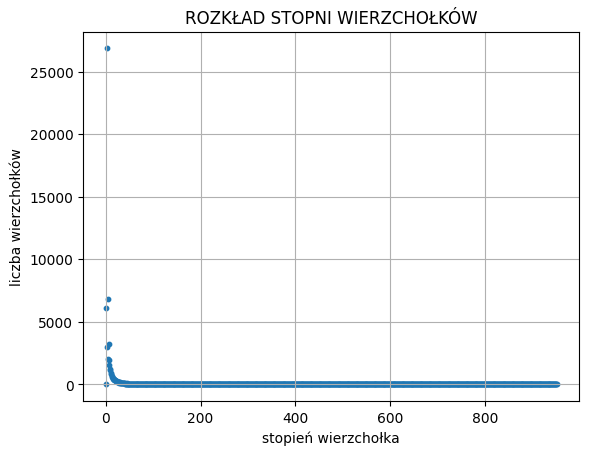

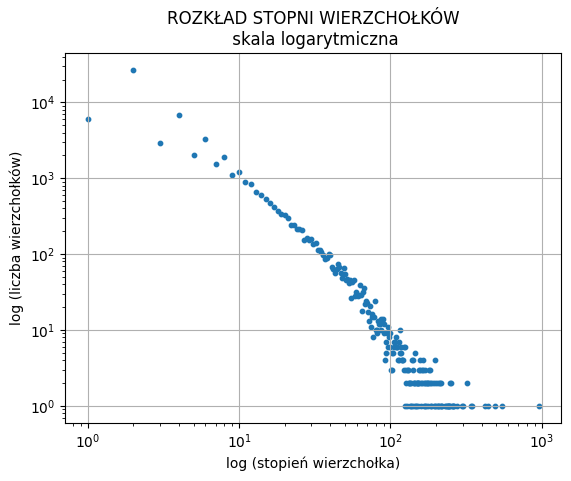

In [48]:
# 5 - ROZKŁAD STOPNI WIERZCHOŁKÓW
import matplotlib.pyplot as plt

degrees = [val for (node, val) in G.degree()]

degree_histogram = nx.degree_histogram(G)

degree_values = list(range(len(degree_histogram)))

plt.scatter(degree_values, degree_histogram, marker='o', s=10)
plt.xlabel('stopień wierzchołka')
plt.ylabel('liczba wierzchołków')
plt.title('ROZKŁAD STOPNI WIERZCHOŁKÓW')
plt.grid(True)
plt.show()

plt.scatter(degree_values, degree_histogram, marker='o', s=10)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log (stopień wierzchołka)')
plt.ylabel('log (liczba wierzchołków)')
plt.title('ROZKŁAD STOPNI WIERZCHOŁKÓW\n skala logarytmiczna')
plt.grid(True)
plt.show()


Skala logarytmiczna pozwala na równomierne przedstawienie szerokiego zakresu wartości stopni wierzchołków. W sieciach złożonych, gdzie występują wierzchołki o bardzo różnych stopniach, skala logarytmiczna pozwala zobaczyć informacje dotyczące wierzchołków o niższych stopniach, które mogłyby być zdominowane przez wierzchołki o wyższych stopniach na standardowym wykresie liniowym (pokazanym u góry).

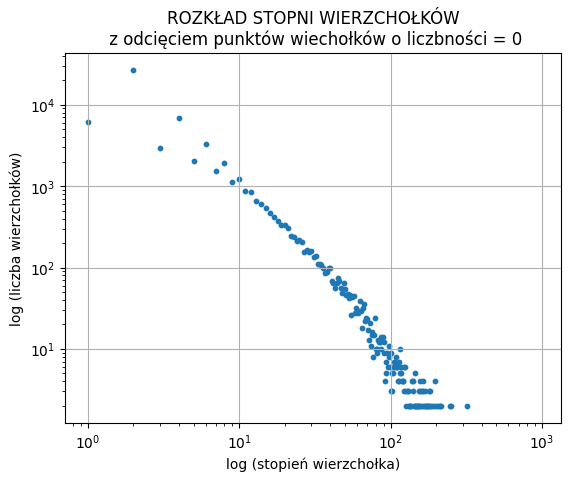

In [49]:
# 5 - ROZKŁAD STOPNI WIERZCHOŁKÓW + FILTROWANIE WIERCHOŁKÓW O ZEROWYM WYSTĘPOWANIU
filtered_indices = [i for i, val in enumerate(degree_histogram) if val not in [1]]

filtered_degree_values = [i for i in range(len(degree_histogram)) if i in filtered_indices]
filtered_degree_histogram = [degree_histogram[i] for i in filtered_indices]

plt.scatter(filtered_degree_values, filtered_degree_histogram, marker='o', s=10)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log (stopień wierzchołka)')
plt.ylabel('log (liczba wierzchołków)')
plt.title('ROZKŁAD STOPNI WIERZCHOŁKÓW\n z odcięciem punktów wiechołków o liczbności = 0')
plt.grid(True)
plt.show()

Na powyższym wykresie zostały pominięte punkty odpowiadające wierchołkom, które nie występują w analizowanej sieci ("odcięcie ogona"). Pozwala to na lepszą widoczność struktury istotnego obszaru oraz nie wpływa na późniejsze obliczenia regresji. Dodatkowo można jeszcze bardziej ograniczyć zakres liczby wierzchołków, np. w ten sposób:

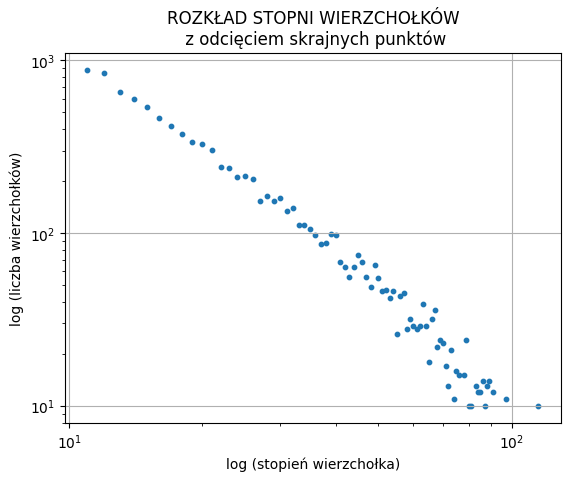

In [50]:
# 5 - ROZKŁAD STOPNI WIERZCHOŁKÓW + SILNIEJSZE FILTROWANIE

more_filtered_indices = [i for i, val in enumerate(degree_histogram) if (val >= 10 and val <= 1000)]

more_filtered_degree_values = [i for i in range(len(degree_histogram)) if i in more_filtered_indices]
more_filtered_degree_histogram = [degree_histogram[i] for i in more_filtered_indices]

plt.scatter(more_filtered_degree_values, more_filtered_degree_histogram, marker='o', s=10)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log (stopień wierzchołka)')
plt.ylabel('log (liczba wierzchołków)')
plt.title('ROZKŁAD STOPNI WIERZCHOŁKÓW\n z odcięciem skrajnych punktów')
plt.grid(True)
plt.show()

Wykres logarytmiczny spontanicznych skojarzeń słownych przypomina funkcję liniową, to oznacza, że istnieje mało wierzchołków o wielu krawędziach (które mogą być "słownymi hubami" - czyli kojarzą się z dużą ilością słów), a z kolei bardzo dużo jest wierchołków o dość jednoznaczniej skojarzeniowości.

Wierzchołki o niższych stopniach mogą być bardziej wyspecjalizowane, co oznacza, że są silnie powiązane z określonymi kategoriami, tematami lub kontekstami, np. słownictwo informatyczne lub geograficzne.


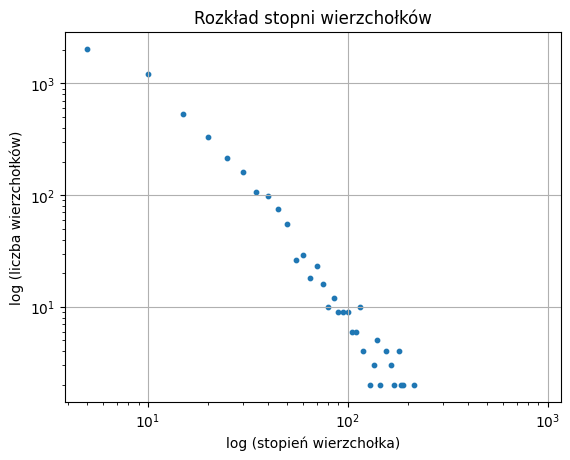

In [51]:
# 6 - PRZEDZIAŁY LOGARYTMICZNE

k = 5

filtered_degree_values = [i for i in range(len(filtered_degree_histogram)) if i in filtered_indices and i % k == 0]
filtered_degree_histogram = [filtered_degree_histogram[i] for i in filtered_degree_values]

plt.scatter(filtered_degree_values, filtered_degree_histogram, marker='o', s=10)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log (stopień wierzchołka)')
plt.ylabel('log (liczba wierzchołków)')
plt.title('Rozkład stopni wierzchołków')
plt.grid(True)
plt.show()


W powyższej części zadania, dane zostały podzielone na przedziały rozlokowane logarytmicznie. W praktycznym ujęciu "przerzedza" nam to wykres, a jest to pomocne w redukcji wpływu wartości odstających, które mogą mieć znaczny wpływ na wyniki analizy regresji.

Wykładnik rozkładu potęgowego (alpha): -2.213356155022062

Power-law exponent (przeciwieństwo nachylenia): 2.213356155022062


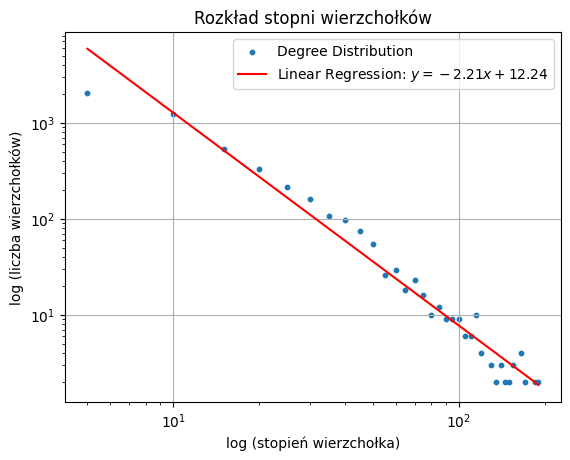

In [66]:
# 6 - REGRESJA

import numpy as np
from scipy.stats import linregress

degree_histogram = nx.degree_histogram(G)

# odrzucenie danych brzechowych
limited_indices = [i for i, val in enumerate(degree_histogram) if val not in [0, 1]]

# podział na przedziały
k = 5
filtered_degree_values = [i for i in range(len(degree_histogram)) if i in limited_indices and i % k == 0]
filtered_degree_histogram = [degree_histogram[i] for i in filtered_degree_values]

plt.scatter(filtered_degree_values, filtered_degree_histogram, marker='o', s=10, label='Degree Distribution')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log (stopień wierzchołka)')
plt.ylabel('log (liczba wierzchołków)')
plt.title('Rozkład stopni wierzchołków')
plt.grid(True)

# regresja liniowa na skali log-log
x = np.log(filtered_degree_values)
y = np.log(filtered_degree_histogram)

slope, intercept, r_value, p_value, std_err = linregress(x, y)

plt.plot(filtered_degree_values, np.exp(intercept) * filtered_degree_values**slope, 'r', label=f'Linear Regression: $y = {slope:.2f}x + {intercept:.2f}$')

print(f'Wykładnik rozkładu potęgowego (alpha): {slope}\n')

exponent = -slope
print("Power-law exponent (przeciwieństwo nachylenia):", exponent)

plt.legend()
plt.show()

Dzięki przekształceniu danych przy użyciu funkcji logarytmicznej oraz dodatkowych operacjach, otrzymaliśmy na wykresie liniowy wzorzec, na który możemy nałożyć prostą regresji liniowej (równanie jest pokazane na wykresie).

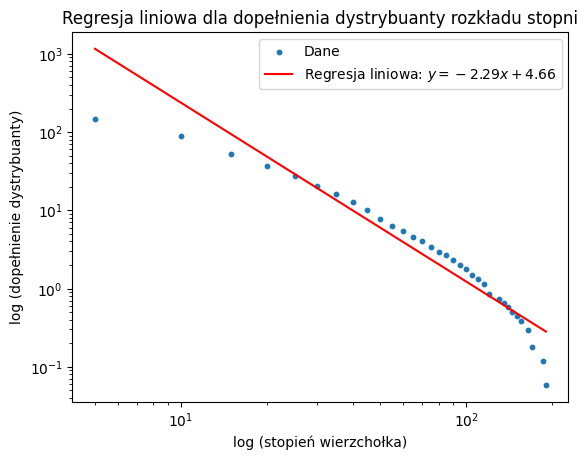

Wykładnik rozkładu potęgowego (gamma): -2.2877173926161225


In [61]:
# 6 - REGRESJA DLA DYSTRYBUANTY

degrees = filtered_degree_values
degree_histogram = filtered_degree_histogram

cumulative_distribution = np.cumsum(degree_histogram[::-1])[::-1] / len(degrees)


log_degrees = np.log10(filtered_degree_values[1:])      # żeby nie było błędu log(0)
log_cdf = np.log10(cumulative_distribution[1:])

slope, intercept, r_value, p_value, std_err = linregress(log_degrees, log_cdf)


plt.scatter(filtered_degree_values, cumulative_distribution, marker='o', s=10, label='Dane')
plt.plot(filtered_degree_values, 10**(intercept + slope * np.log10(filtered_degree_values)), 'r', label=f'Regresja liniowa: $y = {slope:.2f}x + {intercept:.2f}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log (stopień wierzchołka)')
plt.ylabel('log (dopełnienie dystrybuanty)')
plt.title('Regresja liniowa dla dopełnienia dystrybuanty rozkładu stopni')
plt.legend()
plt.show()

print(f'Wykładnik rozkładu potęgowego (alpha): {slope}')


W powyższym podpunkcie przeprowadzona jest analiza regresji na dystrybuancie kumulacyjnej stopni wierzchołków w grafie.

Dystrybuanta oferuje pełniejsze spojrzenie na rozkład stopni wierzchołków, ponieważ uwzględnia nie tylko średnią (jak w przypadku normalnego rozkładu), ale także informacje o rozkładzie stopni w każdym punkcie. Natomiast w naszym przypadku różnica wykładnika rozkładu potęgowego na regresji dystrybuanty w porównaniu do poprzedniego wykresu jest bardzo niewielka. To tylko podkreśla, że duża liczba wierzchołków ma niskie stopnie, ale jednocześnie istnieje niewielka liczba wierzchołków (hobów), które mają wysokie stopnie.

In [ ]:
# 7 - WYKRES HILL'a

def Hill_estimator(data):
    """
    Returns the Hill Estimators for some 1D data set.
    """    
    Y = np.sort(data)
    n = len(Y)
 
    Hill_est = np.zeros(n-1)
 
    for k in range(0, n-1):
        summ = 0
 
        for i in range(0,k+1):
            summ += np.log(Y[n-1-i]) - np.log(Y[n-2-k])
       
        Hill_est[k] = (1 / (k+1)) * summ
 
    kappa = 1. / Hill_est
    return kappa

n_obs = len(degree_histogram)
k_max = int(round(0.1*n_obs))
k_min = 10
 
kap_loss = Hill_estimator(degree_histogram)
 
plt.plot(np.arange(k_min,k_max), kap_loss[k_min-1:k_max-1], 'red')

Wykres Hill's został stworzony przy pomocy dostępnej biblioteki 'Hill_estimator'. Jego kształt potwierdza wczesniejsze obserwacje rozkładu potęgowego - liczba wiechołków maleje wraz ze wzrostem stopnia wiechołka. Funkcja na powyższym wykresie, jest funkcją malejąca. Występują w niej odchyłki, ale prawdopodobnie wraz ze wzrostem danych w sieci były by one mniejsze.